In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
import joblib
%matplotlib inline

random_state=42

ModuleNotFoundError: No module named 'seaborn'

In [2]:
!pip install seaborn

In [2]:
# from google.colab import drive
# drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
df = pd.read_csv("../data_given/diabetes.csv", sep = ',', encoding='utf-8')

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. 
- All patients here are females at least 21 years old of Pima Indian heritage.
- <b>Outcome</b> is the TARGET VARIABLE

In [8]:
print(f'Shape: {df.shape}')

Shape: (768, 9)


In [9]:
## checking missing values
print(f"-----Missing values----- \n{df.isnull().sum()}")

-----Missing values----- 
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


0    500
1    268
Name: Outcome, dtype: int64


Text(0.5, 1.0, 'Distribution in target variabel')

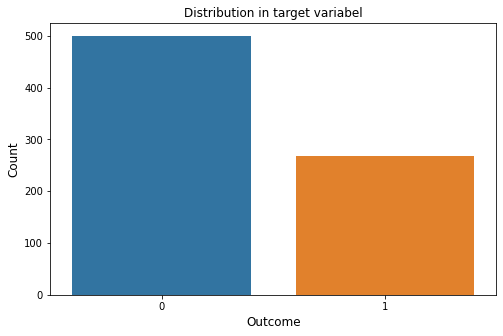

In [10]:
print(df['Outcome'].value_counts())
plt.figure(figsize = (8,5))
sns.countplot(x = df['Outcome'])
plt.xlabel('Outcome', size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution in target variabel', size = 12)

In [11]:
df.drop(['Outcome'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


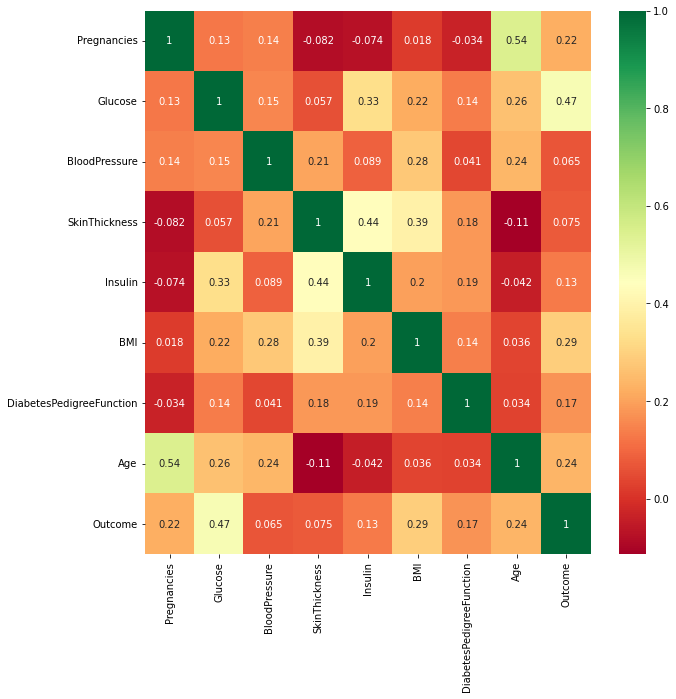

In [12]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (10,10))
#plot heatmap
g = sns.heatmap(df[top_corr_features].corr(), annot = True, cmap = 'RdYlGn')

In [13]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [16]:
osamp = RandomOverSampler(random_state=random_state)
X, y = osamp.fit_resample(X, y)                    

In [17]:
print(y.value_counts())

1    500
0    500
Name: Outcome, dtype: int64


In [18]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [19]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [20]:
## Feature importances
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [21]:
print(model.feature_importances_)

[0.11363354 0.22875599 0.09480537 0.087059   0.07536674 0.14346698
 0.10993308 0.14697929]


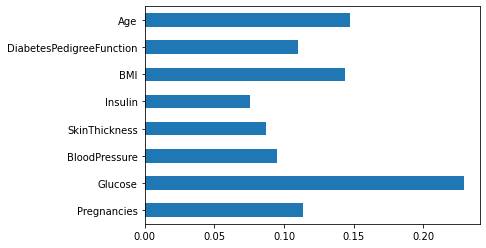

In [22]:
feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances.plot(kind='barh')
plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = random_state)

print('Shape of X_train :{}'.format(X_train.shape))
print('Shape of X_test :{}'.format(X_test.shape))

Shape of X_train :(800, 8)
Shape of X_test :(200, 8)


## Model 1: RandomForestClassifier

In [24]:
# Hyperparameters
n_estimators = [int(x) for x in np.linspace(100, 1200, 12)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(5, 30, 6)]

min_samples_split = [2, 5, 10, 15, 100]

min_samples_leaf = [1, 2, 5, 10]

In [25]:
param_grid = {
    'n_estimators' : n_estimators,
    'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf
}

In [26]:
rf = RandomForestClassifier()

In [27]:
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score = True,
                               n_iter = 10, 
                               cv = 5,
                               verbose = 2,
                               random_state = random_state,
                               n_jobs = -1
                              )

In [28]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, return_train_score=True, scoring='roc_auc',
                   verbose=2)

In [29]:
#we get the best estimator of the classifier as
rf_best = rf_random.best_estimator_

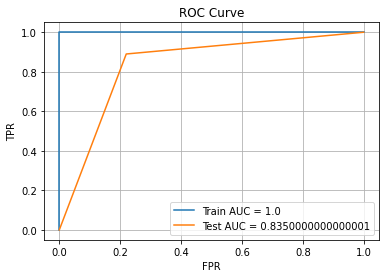

In [30]:
#fitting the data on our best classifier
rf_best.fit(X_train, y_train)

y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "Train AUC = " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC = " + str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()


In [31]:
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    print("The maximum value of tpr*(1-fpr) is ", max(tpr*(1-fpr)), "occurring for the threshold of ", np.round(t,3))
    print('='*50)
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for value in proba:
        if value >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

The maximum value of tpr*(1-fpr) is  1.0 occurring for the threshold of  1


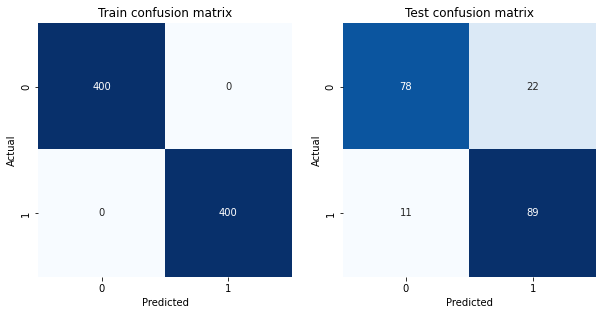

In [32]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
fig, axs = plt.subplots(1,2, figsize = (10,6))

#plotting the train confusion matrix
tr_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(tr_matrix, annot=True,fmt="d",cmap='Blues', ax= axs[0], square = 1, cbar = False)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Train confusion matrix')
axs[0].set_ylim(2.0, 0)

#plotting the test confusion matrix
te_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(te_matrix, annot=True,fmt="d",cmap='Blues', ax = axs[1], square = 1, cbar = False)
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Test confusion matrix')
axs[1].set_ylim(2.0, 0)
plt.show()

## Model 2: XGBClassifier

Estimators =  3 Train Score 0.8066429418742586 test Score 0.8219178082191781
Estimators =  5 Train Score 0.8061831153388823 test Score 0.8110599078341014
Estimators =  7 Train Score 0.8061831153388823 test Score 0.8110599078341014
Estimators =  10 Train Score 0.8125755743651754 test Score 0.8055555555555555
Estimators =  15 Train Score 0.8236744759556103 test Score 0.8056872037914692
Estimators =  20 Train Score 0.8323281061519904 test Score 0.8093023255813954
Estimators =  30 Train Score 0.8361445783132532 test Score 0.8075117370892019
Estimators =  50 Train Score 0.8554360812425329 test Score 0.8246445497630331
Estimators =  70 Train Score 0.8768115942028986 test Score 0.8246445497630331
Estimators =  150 Train Score 0.9196538936959209 test Score 0.8436018957345972
Estimators =  200 Train Score 0.9504950495049505 test Score 0.8490566037735849
Estimators =  300 Train Score 0.976456009913259 test Score 0.8558139534883721
Estimators =  350 Train Score 0.9887920298879203 test Score 0.861

Text(0.5, 1.0, 'Estimators vs score at depth of 3')

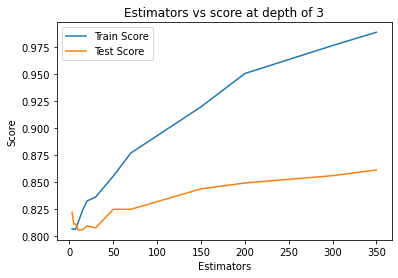

In [37]:
#Trying to find out a range of the best n_estimator by running this snippet
estimators = [3,5,7,10,15,20,30,50,70,150,200,300,350]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(n_estimators = i)
    clf.fit(X_train, y_train)
    train_sc = f1_score(y_train, clf.predict(X_train))
    test_sc = f1_score(y_test, clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)

plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.legend()
plt.title('Estimators vs score at depth of 3')

max_depth =  3 Train Score 0.8431137724550899 test Score 0.8130841121495327
max_depth =  4 Train Score 0.8801897983392645 test Score 0.8333333333333334
max_depth =  5 Train Score 0.9197080291970804 test Score 0.8544600938967136
max_depth =  6 Train Score 0.9642416769420468 test Score 0.8598130841121495
max_depth =  7 Train Score 0.978776529338327 test Score 0.8544600938967136
max_depth =  8 Train Score 0.9875621890547265 test Score 0.8651162790697675
max_depth =  9 Train Score 0.9887920298879203 test Score 0.8450704225352113
max_depth =  12 Train Score 0.991282689912827 test Score 0.8436018957345972
max_depth =  15 Train Score 0.9925187032418954 test Score 0.861244019138756
max_depth =  20 Train Score 0.9925187032418954 test Score 0.861244019138756


Text(0.5, 1.0, 'max_depth vs f1_scores with n_estimator as 10')

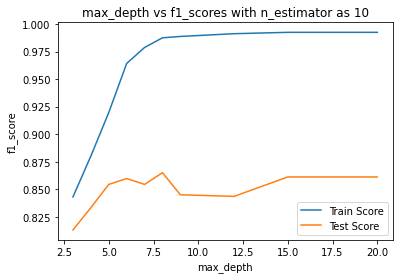

In [39]:
max_depth = [3, 4, 5, 6, 7, 8, 9, 12, 15, 20]
train_scores = []
test_scores = []
for i in max_depth:
    clf = xgb.XGBClassifier(max_depth = i, n_estimators = 35)
    clf.fit(X_train, y_train)
    train_sc = f1_score(y_train, clf.predict(X_train))
    test_sc = f1_score(y_test, clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('max_depth = ',i,'Train Score',train_sc,'test Score',test_sc)

plt.plot(max_depth,train_scores,label='Train Score')
plt.plot(max_depth,test_scores,label='Test Score')
plt.xlabel('max_depth')
plt.ylabel('f1_score')
plt.legend()
plt.title('max_depth vs f1_scores with n_estimator as 10')

learning_rate =  0.01 Train Score 0.8494749124854141 test Score 0.8285714285714286
learning_rate =  0.1 Train Score 0.9197080291970804 test Score 0.8544600938967136
learning_rate =  0.15 Train Score 0.9468479604449938 test Score 0.8436018957345972
learning_rate =  0.2 Train Score 0.9628712871287128 test Score 0.8516746411483254
learning_rate =  0.3 Train Score 0.9826302729528535 test Score 0.8584905660377358
learning_rate =  0.5 Train Score 1.0 test Score 0.8558139534883721
learning_rate =  1 Train Score 1.0 test Score 0.8530805687203792


Text(0.5, 1.0, 'learning_rate vs f1_scores with n_estimator=50, max_depth=5')

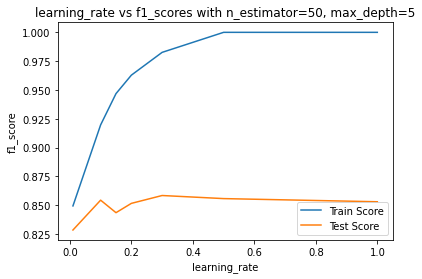

In [40]:

#Trying to find out a range of the best learning_rate by running this snippet
learning_rate = [0.01, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
train_scores = []
test_scores = []
for i in learning_rate:
    clf = xgb.XGBClassifier(max_depth = 5, learning_rate = i, n_estimators = 35)
    clf.fit(X_train, y_train)
    train_sc = f1_score(y_train, clf.predict(X_train))
    test_sc = f1_score(y_test, clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('learning_rate = ',i,'Train Score',train_sc,'test Score',test_sc)

plt.plot(learning_rate,train_scores,label='Train Score')
plt.plot(learning_rate,test_scores,label='Test Score')
plt.xlabel('learning_rate')
plt.ylabel('f1_score')
plt.legend()
plt.title('learning_rate vs f1_scores with n_estimator=50, max_depth=5')

min_child_weight =  1 Train Score 0.9197080291970804 test Score 0.8544600938967136
min_child_weight =  5 Train Score 0.8859223300970873 test Score 0.8262910798122066
min_child_weight =  10 Train Score 0.8574908647990256 test Score 0.8075117370892019
min_child_weight =  20 Train Score 0.825822168087698 test Score 0.8000000000000002
min_child_weight =  40 Train Score 0.8039457459926017 test Score 0.7647058823529411
min_child_weight =  60 Train Score 0.7467700258397933 test Score 0.7142857142857142
min_child_weight =  80 Train Score 0.7383059418457648 test Score 0.7236180904522613
min_child_weight =  100 Train Score 0.6175 test Score 0.6060606060606062


Text(0.5, 1.0, 'min_child_weight vs scores with n_estimator=100, max_depth=5, learning_rate = 0.05')

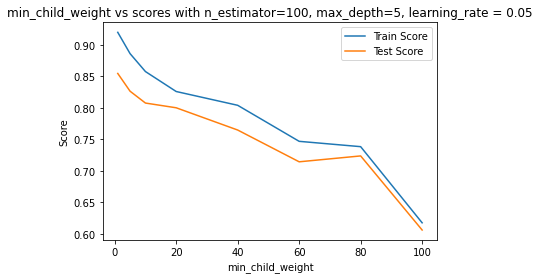

In [41]:

#Trying to find out a range of the best min_child_weight by running this snippet
min_child_weight = [1, 5, 10, 20, 40, 60, 80, 100]
train_scores = []
test_scores = []
for i in min_child_weight:
    clf = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.1, n_estimators = 35, min_child_weight = i)
    clf.fit(X_train, y_train)
    train_sc = f1_score(y_train, clf.predict(X_train))
    test_sc = f1_score(y_test, clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('min_child_weight = ',i,'Train Score',train_sc,'test Score',test_sc)

plt.plot(min_child_weight,train_scores,label='Train Score')
plt.plot(min_child_weight,test_scores,label='Test Score')
plt.xlabel('min_child_weight')
plt.ylabel('Score')
plt.legend()
plt.title('min_child_weight vs scores with n_estimator=100, max_depth=5, learning_rate = 0.05')

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform


model = xgb.XGBClassifier(min_child_weight=1)
params = {'n_estimators' : sp_randint(30, 40),
          'max_depth' : sp_randint(5, 6),
          'learning_rate' : np.linspace(0.1, 0.15, num = 10)}
xgb_random = RandomizedSearchCV(model, params, n_iter=10, cv = 10, scoring = 'f1', return_train_score = True, random_state = random_state)


xgb_random.fit(X_train, y_train)
print('mean train scores',xgb_random.cv_results_['mean_train_score'])
print('mean test scores',xgb_random.cv_results_['mean_test_score'])

mean train scores [0.93994042 0.94206416 0.95119128 0.93477618 0.94206416 0.94110437
 0.9398463  0.93934018 0.9317895  0.93455546]
mean test scores [0.82741576 0.82411218 0.83139617 0.82648894 0.82411218 0.82021549
 0.82670411 0.8270049  0.83130985 0.82487712]


In [46]:
print(xgb_random.best_estimator_)

XGBClassifier(learning_rate=0.13333333333333333, max_depth=5, n_estimators=39)


In [47]:
best_clf = xgb_random.best_estimator_

In [48]:
best_clf.fit(X_train, y_train)

XGBClassifier(learning_rate=0.13333333333333333, max_depth=5, n_estimators=39)

In [49]:
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

In [50]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9400244798041616
Test f1 score 0.8450704225352113


In [51]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


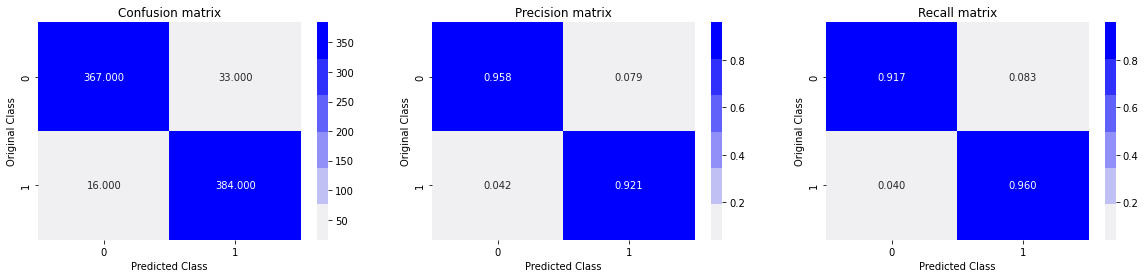

Test confusion_matrix


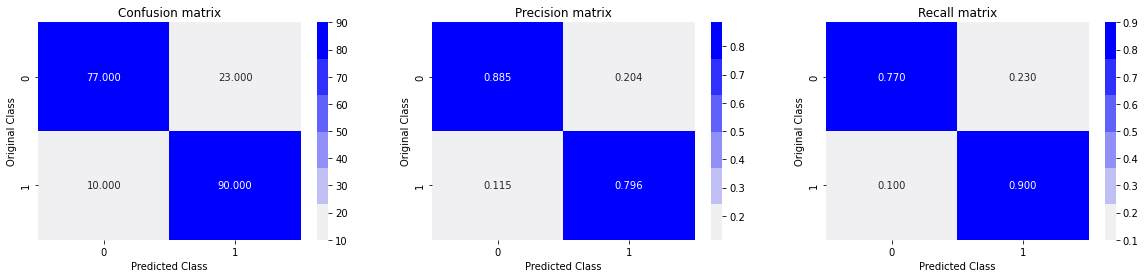

In [52]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

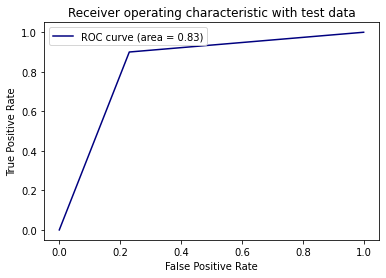

In [53]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

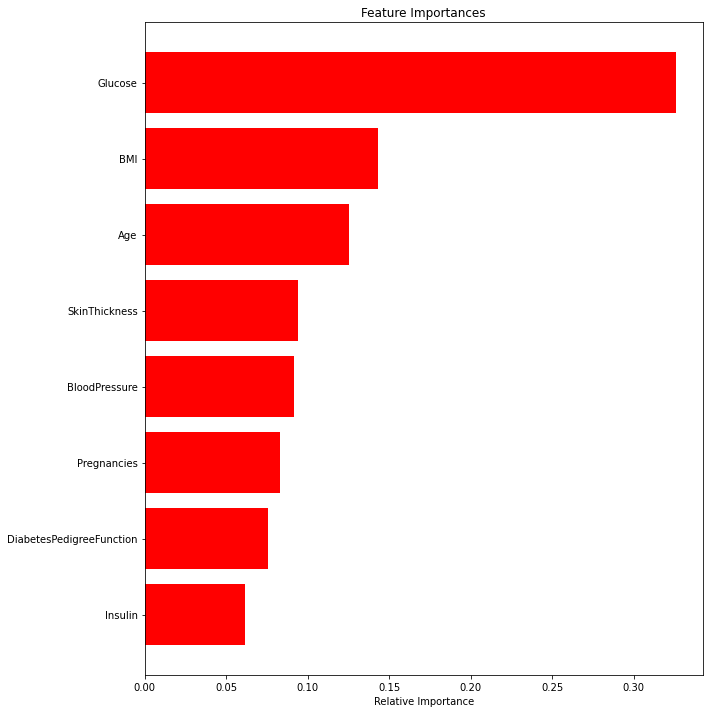

In [54]:
features = X_train.columns
importances = best_clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()